<div class="alert alert-block alert-info">

    
# Calculate Black Hole Spins from Population Synthesis Data DEMO
    
This jupyter notebook introduces the class to calculate black hole spins from population syntehsis data.


Ping Floor Broekgaarden fsbroekgaarden@gmail.com in case of questions <br>
<br>



In [1]:
# the following line just makes the cells appear wider:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


<div class="alert alert-block alert-warning">

Throughout this notebook and in class we will use several acronyms and definitions listed below    
    
    
    


# 0.) Instructions 

The code below provides python code for different post-processing spin prescriptions that can be applied to COMPAS or other population synthesis data. 

The script contains the spin class with the different spin prescriptions, 
several examples of how to run & plot the code and apply the spins to COMPAS data, 
and examples that test spin prescriptions with generated values 

To apply this example to COMPAS data and follow the exact same steps, please download the `Z_0.001.zip` file (2GB) from https://zenodo.org/record/6346444 

 - note that at the bottom of this jupyter notebook there is also instructions how to adapt this class to older COMPAS data (from before COMPAS's public release). 
   For this you will download the data Fiducial.zip from Zenodo: https://zenodo.org/record/5178777 (BHNS) or from https://zenodo.org/record/5651073 (BHBH). These downloads can take some time, so you might want to already start them. 
    

### Definitions
 - BH: Black Hole
 - NS: Neutron Star
 - Primary: in this notebook always refers to the star that was most massive at the zero age main sequence (ZAMS)
 - Secondary: in this notebook always refers to the star that was least massive at the zero age main sequence (ZAMS)
 - ZAMS: Zero Age Main Sequence: this is in COMPAS where stars start their lives. 
    

<div class="alert alert-block alert-success"> 

# 1.) the Spin class 

the spin class, and all its functions is provided in the Python file in this directory called `spin_class.py` we can load in the class and all its functions using the following lines/
    
<div>

In [2]:
import sys
from spin_class import calculate_spin 

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
# from astropy import units as u
# from astropy import constants as c


# 2.) Some Plotting code 

In [3]:

# some plotting code, it should be fairly straightforward what the code does

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True, ):
    """
    Some code to do the layout for axes in matplotlib in a nice way 
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    if labelSizeMajor==10:
        ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    else:
        ax.set_xlabel(nameX, fontsize=labelSizeMajor,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=labelSizeMajor,labelpad=labelpad)#, fontweight='bold')  

    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax



def plot_scatter_spin(spin_values, spin_model_name):
    """
    Creates scatter plot to compare pre-second-SN properties (WR mass, Period), and final BH spin
    Can be used to compare to plots shown in Bavera et al. (2021); https://arxiv.org/abs/2105.09077
    """
    
    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(spin.mWR[0:], spin.PeriodPreSN2[0:],  c=spin_values[0:])

    ylabel=r'Period [day]'
    xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '

    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1, 70)
    plt.ylim(0.05, 10)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 


    
    
def plot_scatter_Belczynski_spin(spin_values, spin_model_name):
    """
    Creates plot that shows the spin values versus the CO core mass to compare to Fig 1. in Belczynski et al. (2020)
    https://www.aanda.org/10.1051/0004-6361/201936528 
    """

    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(spin.MassCOM1CoreSN[0:], spin_values[0:],  c=np.log10(spin.metallicitySystems[0:]))



    ylabel=r'spin m1 '
    xlabel=r'$m_{\rm{CO}} \, [M_{\odot}]$ '

    plt.xlim(0, 70)

    cbar = plt.colorbar()
    cbar.set_label(r'$Z$', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    


def plot_histogram_spin(spin_values, spin_model_name, weights=None, yscaleLOG=False):
    """
    Creates weighted histogram of black hole spins (spin_values)
    """

    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.hist(spin_values, weights=weights, bins=100)

    ylabel=r'PDF (rate) ' 
    xlabel=r'spin '

    plt.xlim(0, 1)
    
    if yscaleLOG==True:
        ax.set_yscale('log')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 

    
def plot_scatter_general(xx, yy, cc, spin_model_name, ylabel=r'Period [day]', xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '):
    """ makes a scatter plot of xx vs yy with colors based on cc"""

    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(xx, yy,  c=cc)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    
    
    

# 3.) Some Examples 

<div class="alert alert-block alert-warning">

    

## Example 1: random uniform spin for each Black Hole (BH)

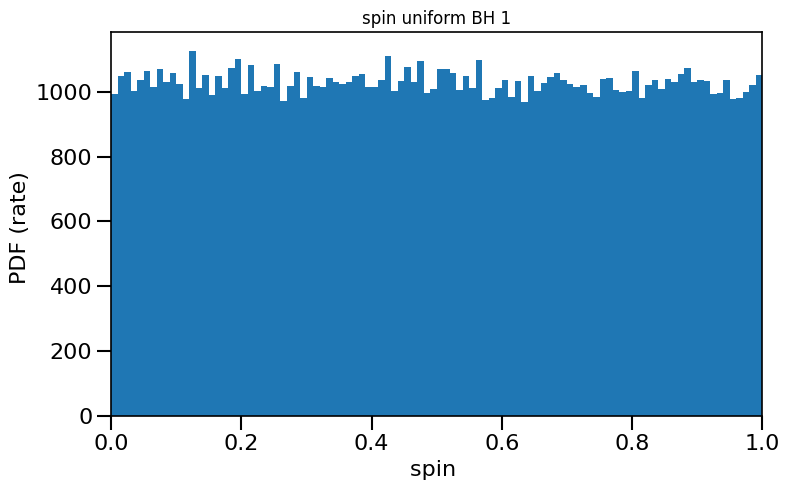

In [4]:

# plot data while assigning random uniform spins for all BBHs
path = '/Volumes/Andromeda2/Z_0.001/COMPAS_Output.h5' # change this line! 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.random_uniform_spin(low=0.0,high=1)

fdata = h5.File(path)
plot_histogram_spin(spin_values=(spinM1), spin_model_name=' uniform BH 1')




<div class="alert alert-block alert-warning">
    
## Example 2: all BH spin have a fixed value

the spins equal  [0.5 0.5 0.5 ... 0.5 0.5 0.5]


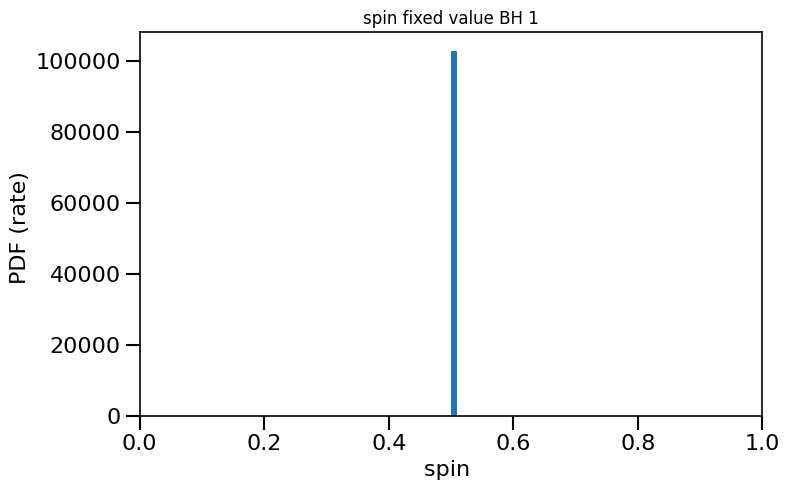

In [6]:
# plot spin for all BBHs in dataset, giving them a fixed spin value

path = '/Volumes/Andromeda2/Z_0.001/COMPAS_Output.h5' # change this line! 
spinM1, spinM2  = spin.fixed_value_spin(spin_value=0.5)
print('the spins equal ', spinM1)

plot_histogram_spin(spin_values=(spinM1), spin_model_name=' fixed value BH 1')


<div class="alert alert-block alert-warning">

## Example 3: second formed black hole obtains spin through tides at Wolf-Rayet (WR)-BH stage 
Often described as "Bavera+21 prescription" or "Efficient core-envelope coupling presciption", or "Fuller" model

In [7]:
# give all black holes in the dataset a spin from the Bavera prescription 
path = '/Volumes/Andromeda2/Z_0.001/COMPAS_Output.h5' # change this line to your output data! 
spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Bavera21()



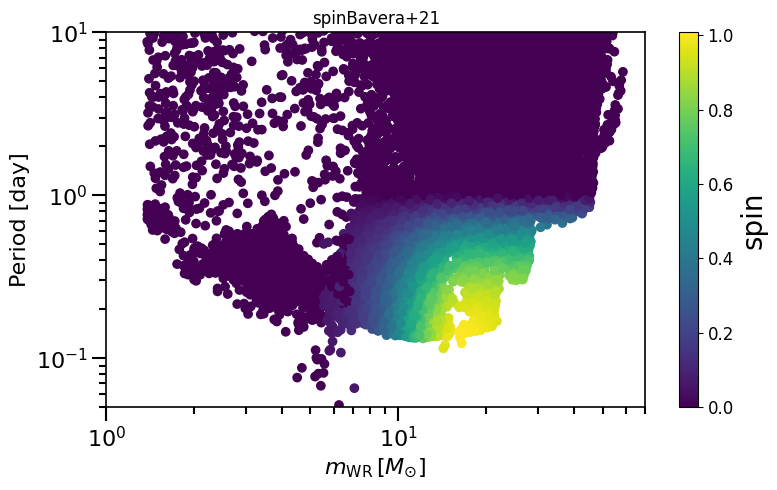

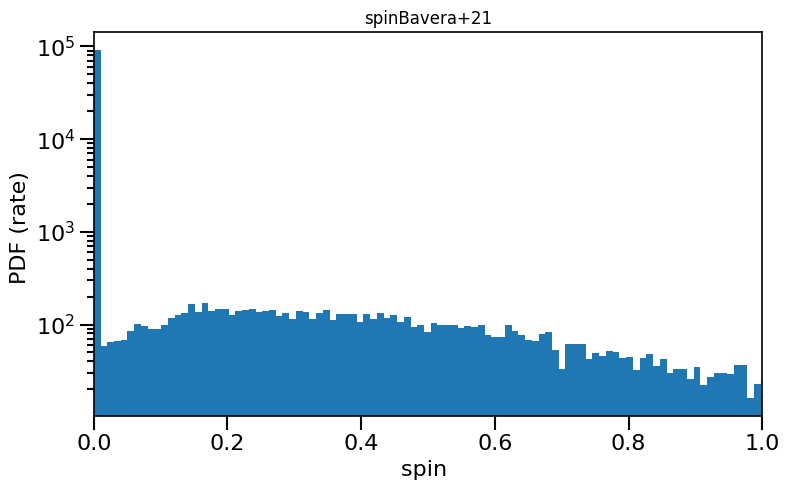

In [8]:
# plot the spins 

# note that we are plotting both the spinM2 and spinM1, spinM1 can only be nonzero if it went supernova second (due to rejuvenation). This almost never occurs. 
# plot figure showing pre-SN properties 
plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21')

# plot histogram
plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21', yscaleLOG=True)



<div class="alert alert-block alert-warning">

## Example 4: Geneva model based spin (birth BH spin)
based on Belczynski et al. (2020) Fig.1 and Equation 3.

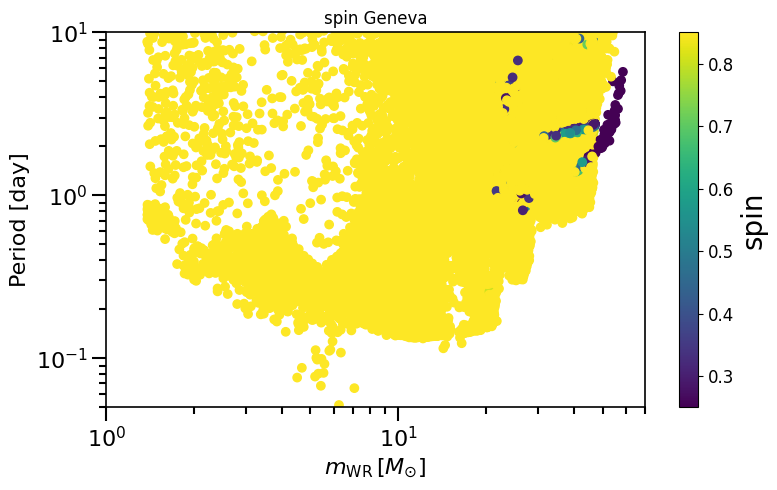

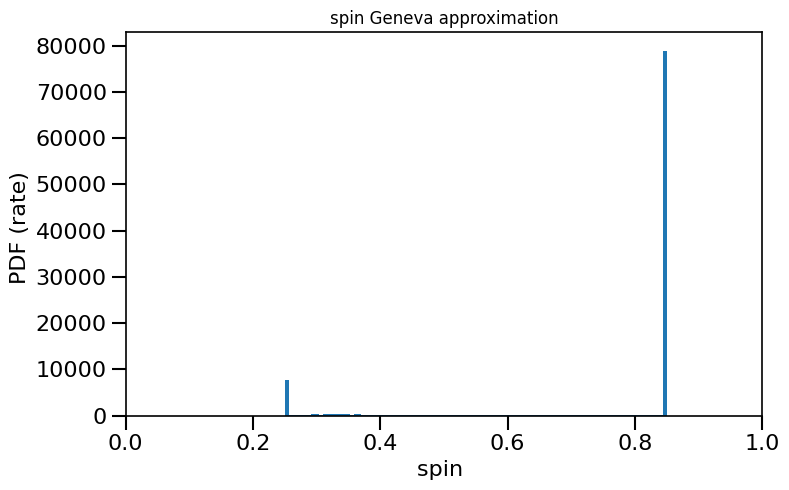

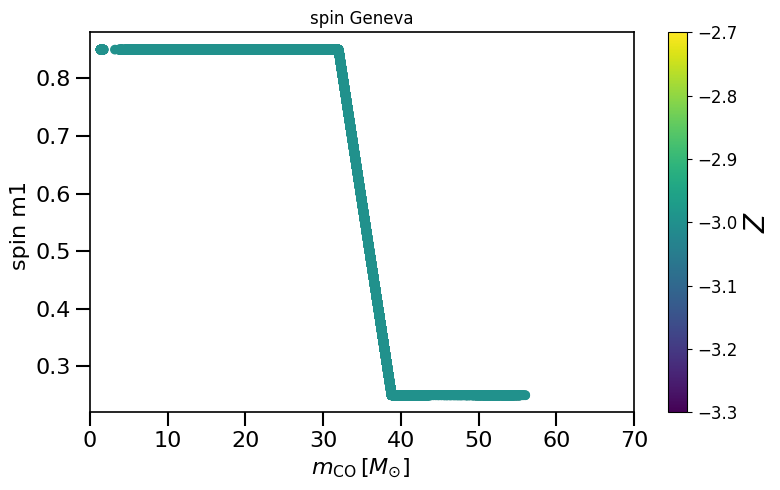

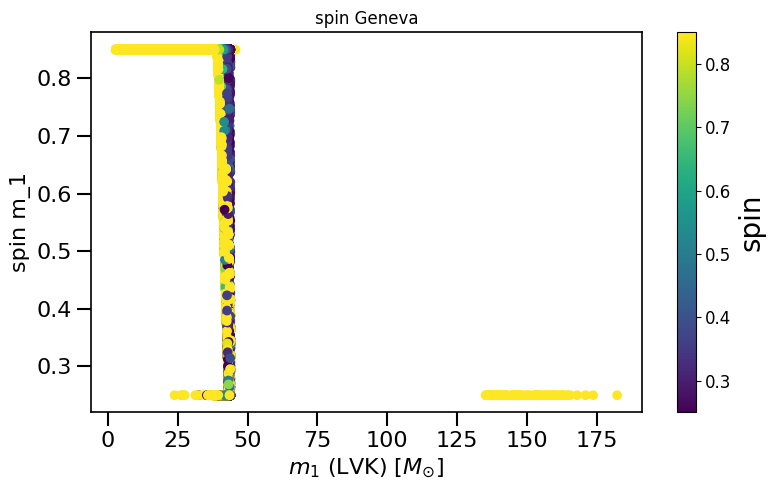

In [9]:
# give all black holes in the dataset a spin from the Geneva model prescription 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.Geneva()


plot_scatter_spin(spin_values=(spinM1), spin_model_name=' Geneva')

plot_histogram_spin(spin_values=(spinM1), spin_model_name=' Geneva approximation')


plot_scatter_Belczynski_spin(spin_values=(spinM1), spin_model_name=' Geneva')



LVKM1 = np.maximum(spin.M1, spin.M2)
plot_scatter_general(xx=LVKM1, yy=spinM1, cc=spinM2, spin_model_name=' Geneva', xlabel=r'$m_1$ (LVK) $[M_{\odot}]$', ylabel='spin m_1')



<div class="alert alert-block alert-warning">

## Example 5:  MESA-model based birth BH spin 
based on Belczynski et al. (2020) Fig.2 and Equation 4.

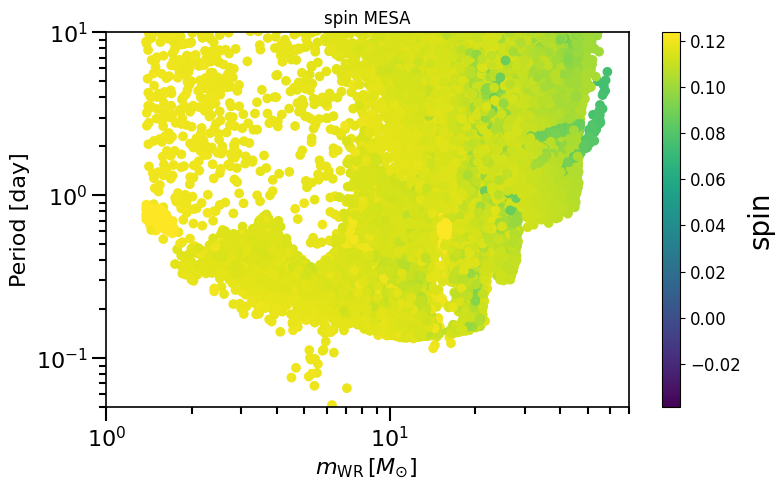

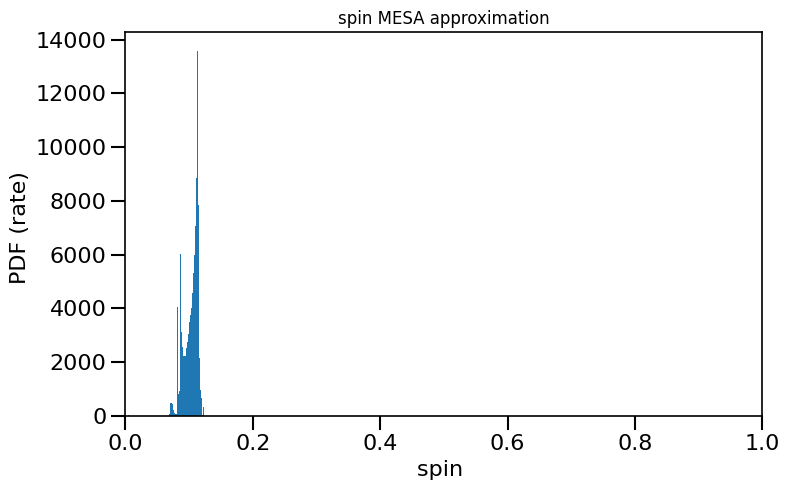

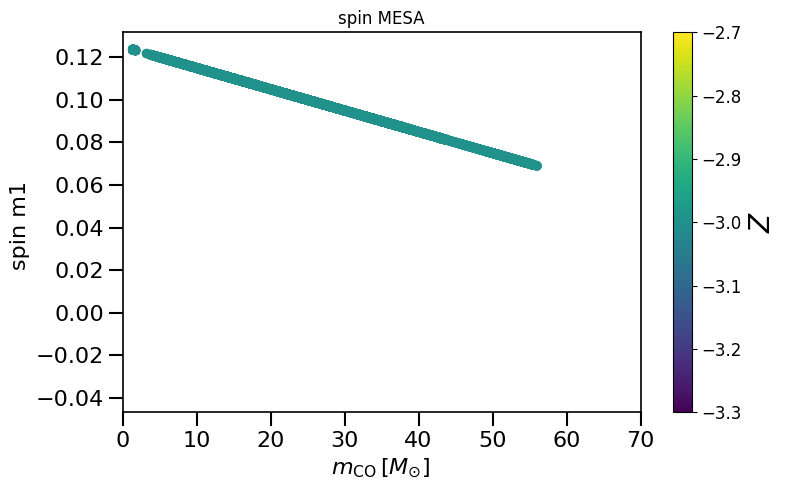

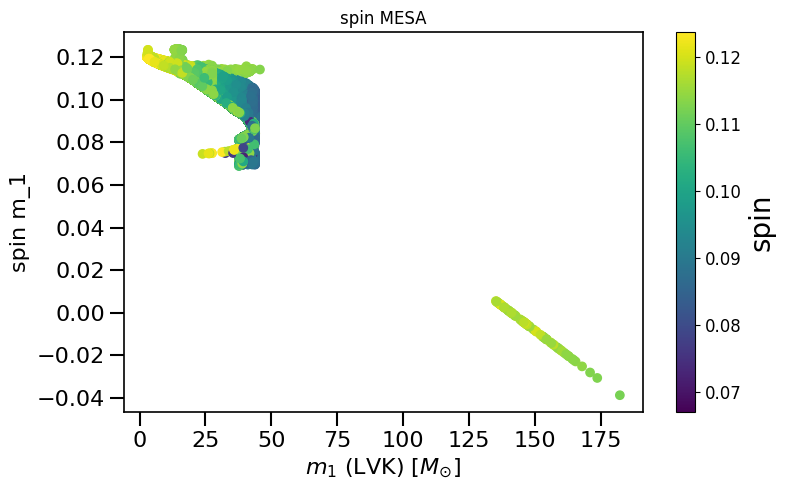

In [10]:
# give all black holes in the dataset a spin from the MESA prescription 

spin = calculate_spin(data_path=path)
spinM1, spinM2  = spin.MESA()


plot_scatter_spin(spin_values=(spinM1), spin_model_name=' MESA')


plot_histogram_spin(spin_values=(spinM1), spin_model_name=' MESA approximation')


plot_scatter_Belczynski_spin(spin_values=(spinM1), spin_model_name=' MESA')


LVKM1 = np.maximum(spin.M1, spin.M2)
plot_scatter_general(xx=LVKM1, yy=spinM1, cc=spinM2, spin_model_name=' MESA', xlabel=r'$m_1$ (LVK) $[M_{\odot}]$', ylabel='spin m_1')



<div class="alert alert-block alert-success"> 

#  -- Extra material --



# 4.) Test of Belczynski prescription 

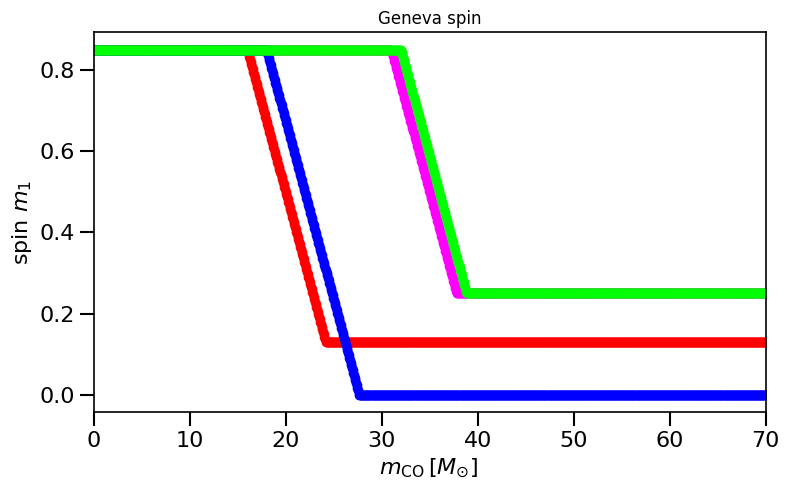

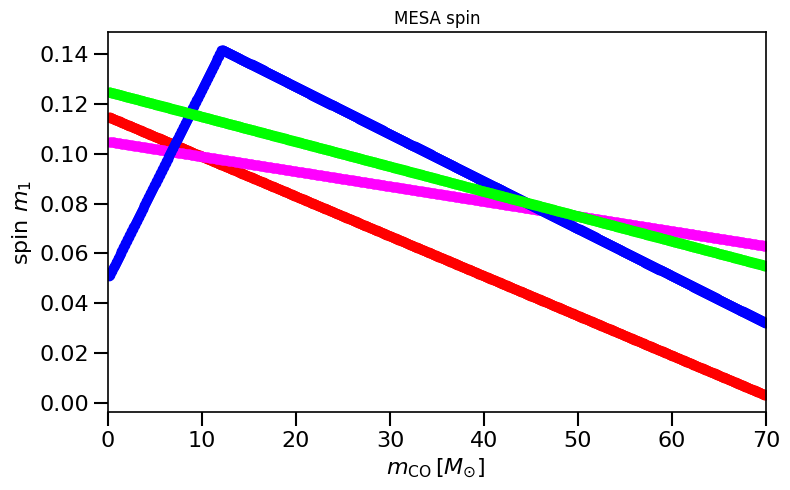

In [11]:
# Below are the Belczynski prescriptions, but coded to test them without a dataset. 


def Z_dependent_spin_param(metallicity_range, prescription_name):
    """ 
    prescription_name in [Geneva, MESA]
    """
    # from Table 1 in http://arxiv.org/abs/2301.01312 


    if metallicity_range >= 0.010:
        return [2.258, 16.0, 24.2, 0.13] if prescription_name=='Geneva' else  [-0.0016, 0.115, np.inf, np.inf, np.inf]

    elif (metallicity_range >= 0.004) & (metallicity_range < 0.010):
        return [3.578, 31.0, 37.8, 0.25] if prescription_name=='Geneva' else  [-0.0006, 0.105, np.inf, np.inf, np.inf]

    elif (metallicity_range >= 0.0012) & (metallicity_range < 0.004):
        return [2.434, 18.0, 27.7, 0.0 ] if prescription_name=='Geneva' else  [0.0076, 0.050, -0.0019, 0.165, 12.09]


    elif (metallicity_range < 0.0012):
        return [3.666, 32.0, 38.8, 0.25] if prescription_name=='Geneva' else  [-0.0010, 0.125, np.inf, np.inf, np.inf]


def Geneva(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN):
    # see from Table 1 in http://arxiv.org/abs/2301.01312 

    spinM1, spinM2 = np.zeros_like(MassCOM1CoreSN), np.zeros_like(MassCOM1CoreSN)
    Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 


    for _, Z_range in enumerate(Z_ranges):

        mask_inside_Z = (metallicitySystems >= Z_range[0]) & (metallicitySystems < Z_range[1]) # mask inside metallicity range
        
        b_, m1_, m2_, a_low = Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='Geneva')

        spinM1[(MassCOM1CoreSN <= m1_)&(mask_inside_Z==1)], spinM2[(MassCOM2CoreSN <= m1_)&(mask_inside_Z==1)] = 0.85, 0.85

        mask_spin1 = (MassCOM1CoreSN > m1_) &  (MassCOM1CoreSN < m2_) & (mask_inside_Z==1)
        mask_spin2 = (MassCOM2CoreSN > m1_) &  (MassCOM2CoreSN < m2_) & (mask_inside_Z==1)
        spinM1[mask_spin1], spinM2[mask_spin2] = (-0.088*MassCOM1CoreSN[mask_spin1]) + b_, (-0.088*MassCOM2CoreSN[mask_spin2]) + b_

        spinM1[(MassCOM1CoreSN >= m2_)&(mask_inside_Z==1)], spinM2[(MassCOM2CoreSN >= m2_)&(mask_inside_Z==1)] = a_low, a_low
    return spinM1, spinM2



def plot_scatter_Belczynski_iteration(ax, spin_values, MassCOM1CoreSN, spin_model_name, color):

    plt.scatter(MassCOM1CoreSN[0:], spin_values[0:], color=color)


    ylabel=r'spin $m_1$'
    xlabel=r'$m_{\rm{CO}} \, [M_{\odot}]$ '

    plt.xlim(0, 70)

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 

    return ax



def MESA(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN):
    '''
    returns spins of the primary (spinM1) and secondary (spinM2) 
    based on the MESA BH natal spin model as described in Belczsynski et al. (2020) 
    See Equation 4 and Fig 2 in https://www.aanda.org/10.1051/0004-6361/201936528 
    this model assumes moderate BH birth spins, with a spin magnitude dependent on metallicity and CO core mass
    Warning: this function currently assumes the two stars have identical metallicity (add a Z mask to change this)
    ''' 
    # MESA spin prescription see from Table 1 in http://arxiv.org/abs/2301.01312 

    # apply spin model on metallicity ranges that linearly span Z values by Belczysnki (cf. http://arxiv.org/abs/2301.01312) 
    Z_ranges = [[0.0, 0.0012], [0.0012, 0.004], [0.004, 0.010], [0.010, 1.0]] # Tab. 1 conditions in  in http://arxiv.org/abs/2301.01312 

    # loop over four metallicity ranges of prescription
    for _, Z_range in enumerate(Z_ranges):
        mask_inside_Z = (metallicitySystems >= Z_range[0]) & (metallicitySystems < Z_range[1])  # mask systems inside metallicity range
        a1_, b1_, a2_, b2_, m1_ = Z_dependent_spin_param(metallicity_range=Z_range[0], prescription_name='MESA')  # obtains metallcity dependent model coefficients 


        ### apply Equation 4 in Belczynski et al. (2020) ###
        # set spins to linear interpolation for CO masses in below m_1 condition:
        mask_spin1 = (MassCOM1CoreSN <= m1_)&(mask_inside_Z==1)
        mask_spin2 = (MassCOM2CoreSN <= m1_)&(mask_inside_Z==1)
        spinM1[mask_spin1], spinM2[mask_spin2] = (a1_*MassCOM1CoreSN[mask_spin1]) + b1_, (a1_*MassCOM2CoreSN[mask_spin2]) + b1_


        if np.isfinite(m1_):
            # set spins to second linear interpolation equation if we are in the Z range where m_1 is not infinite. 
            mask_spin1 = (MassCOM1CoreSN > m1_)&(mask_inside_Z==1)
            mask_spin2 = (MassCOM2CoreSN > m1_)&(mask_inside_Z==1)
            spinM1[mask_spin1], spinM2[mask_spin2] = (a2_*MassCOM1CoreSN[mask_spin1]) + b2_, (a2_*MassCOM2CoreSN[mask_spin2]) + b2_


    return spinM1, spinM2




colors = ['r', 'magenta', 'b', 'lime']

## BELCZYNSKI GENEVA 
# this should reproduce Fig 1 in Belczynski et al. (2020; https://www.aanda.org/10.1051/0004-6361/201936528) if implemented correctly:
f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))


for ind, Z_ in enumerate([0.014, 0.006, 0.002, 0.0004]):
    MassCOM1CoreSN = np.linspace(0.1, 70, 1000)
    MassCOM2CoreSN = np.linspace(0.1, 70, 1000)
    metallicitySystems = Z_*np.ones_like(MassCOM1CoreSN)
    spinM1, spinM2 = Geneva(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN)
    plot_scatter_Belczynski_iteration(ax, spinM1, MassCOM1CoreSN, ' Geneva', color=colors[ind])
plt.title('Geneva spin')
plt.show()





## BELCZYNSKI MESA
# this should reproduce Fig 2 in Belczynski et al. (2020; https://www.aanda.org/10.1051/0004-6361/201936528) if implemented correctly:
f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))



for ind, Z_ in enumerate([0.014, 0.006, 0.002, 0.0004]):
    MassCOM1CoreSN = np.linspace(0.1, 70, 1000)
    MassCOM2CoreSN = np.linspace(0.1, 70, 1000)
    metallicitySystems = Z_*np.ones_like(MassCOM1CoreSN)
    spinM1, spinM2 = MESA(metallicitySystems, MassCOM1CoreSN, MassCOM2CoreSN)
    plot_scatter_Belczynski_iteration(ax, spinM1, MassCOM1CoreSN, ' Geneva', color=colors[ind])
plt.title('MESA spin')
plt.show()





<div class="alert alert-block alert-success"> 

# 5. Spin Class for OLDER COMPAS DATA

To reproduce this, download the data from e.g. Fiducial.zip from Zenodo: https://zenodo.org/record/5178777 (BHNS) or from https://zenodo.org/record/5651073 (BHBH)
when downloaded, change the file directory to point to your datafile with the hdf5 file, and all code should run :)

For this class use the function `class calculate_spin_olderCOMPASdata()` in the spin class python file 

<div class="alert alert-block alert-warning">

## Example 3: second formed black hole obtains spin through tides at Wolf-Rayet (WR)-BH stage 
Often described as "Bavera+21 prescription" or "Efficient core-envelope coupling presciption", or "Fuller" model

In [12]:
# give all black holes in the dataset a spin from the Bavera prescription 

from spin_class import calculate_spin_olderCOMPASdata

path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BBH_A.h5' # change this line! 

spin = calculate_spin_olderCOMPASdata(data_path=path)
spinM1, spinM2  = spin.Bavera21()



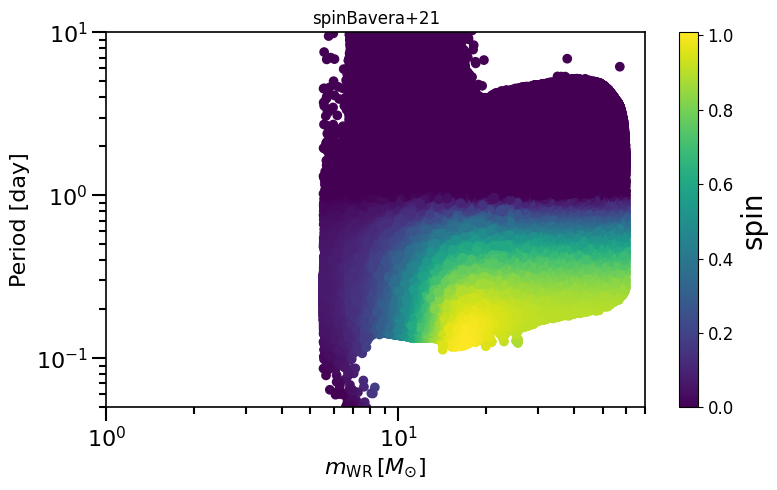

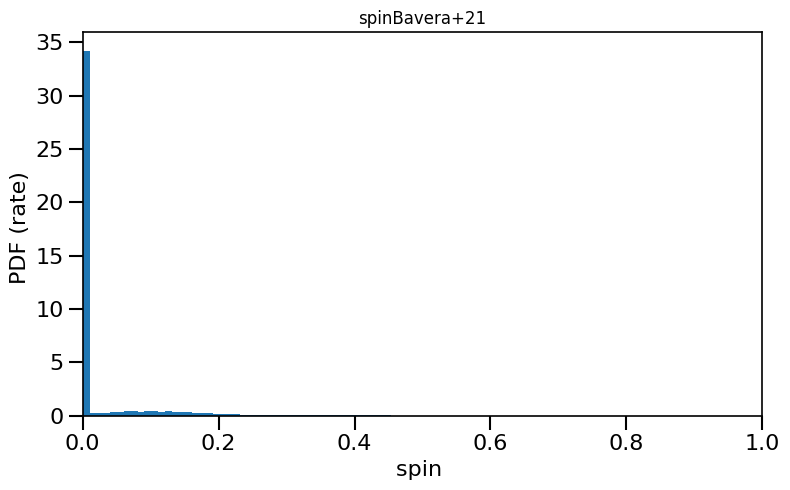

In [13]:
# give all black holes in the dataset a spin from the Bavera prescription 

# note that we are plotting both the spinM2 and spinM1, spinM1 can only be nonzero if it went supernova second (due to rejuvenation). This almost never occurs. 
# plot figure showing pre-SN properties 
plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21')

# plot histogram
fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()
plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21', weights=w_intrinsic)



<div class="alert alert-block alert-warning">


## Example 4: Geneva model based spin (birth BH spin)
based on Belczynski et al. (2020) Fig.1 and Equation 3.

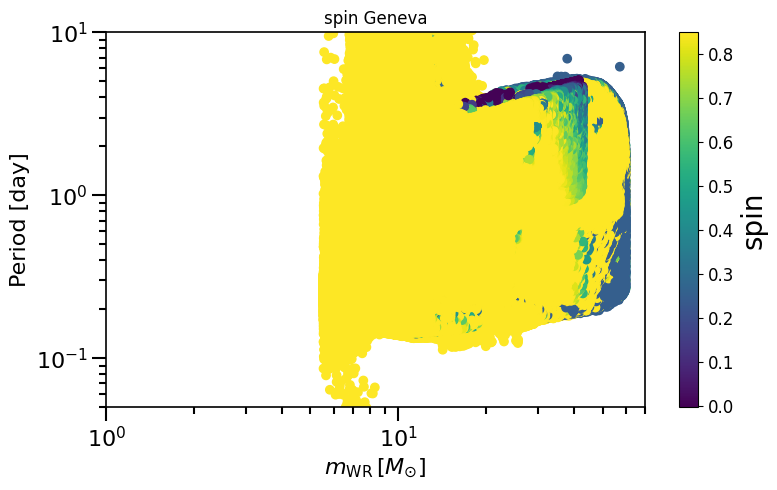

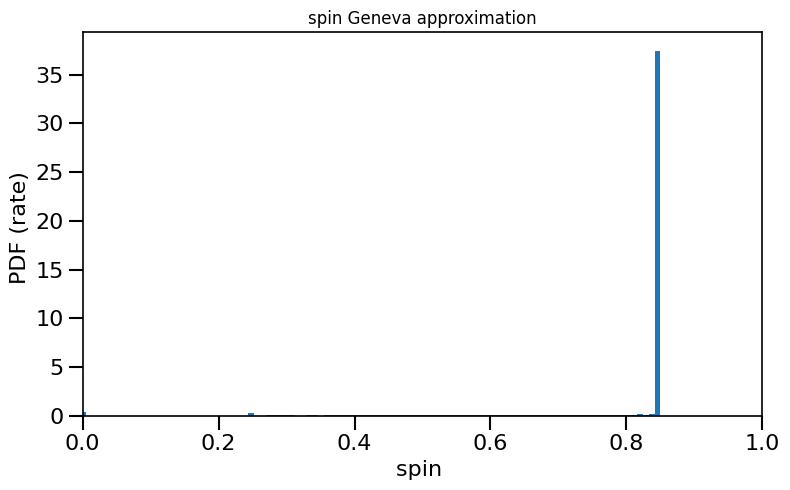

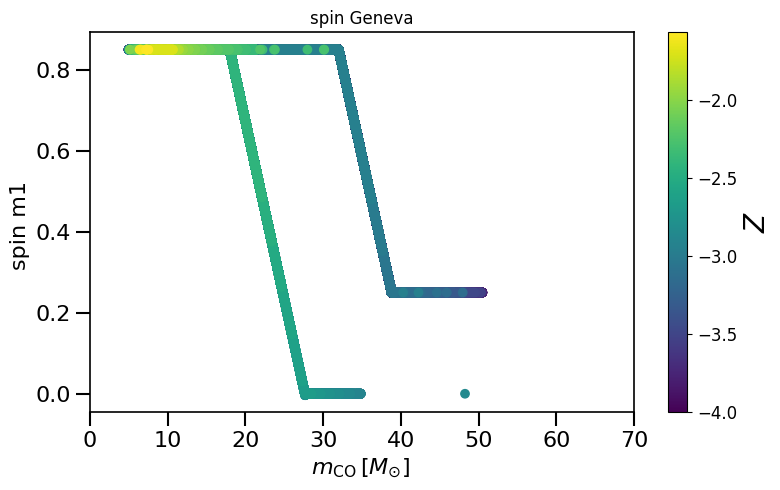

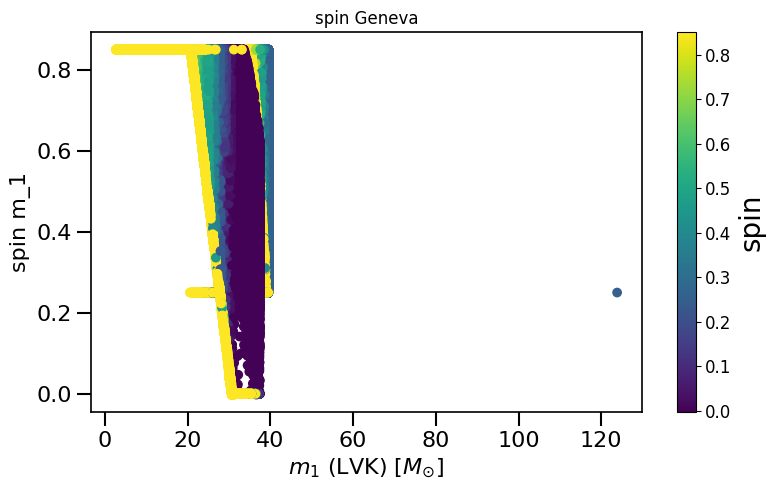

In [14]:
# give all black holes in the dataset a spin from the Geneva model prescription 

spin = calculate_spin_olderCOMPASdata(data_path=path)
spinM1, spinM2  = spin.Geneva()


plot_scatter_spin(spin_values=(spinM1), spin_model_name=' Geneva')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1), spin_model_name=' Geneva approximation', weights=w_intrinsic)


plot_scatter_Belczynski_spin(spin_values=(spinM1), spin_model_name=' Geneva')



LVKM1 = np.maximum(spin.M1, spin.M2)
plot_scatter_general(xx=LVKM1, yy=spinM1, cc=spinM2, spin_model_name=' Geneva', xlabel=r'$m_1$ (LVK) $[M_{\odot}]$', ylabel='spin m_1')



<div class="alert alert-block alert-warning">


## Example 5:  MESA-model based birth BH spin 
based on Belczynski et al. (2020) Fig.2 and Equation 4.

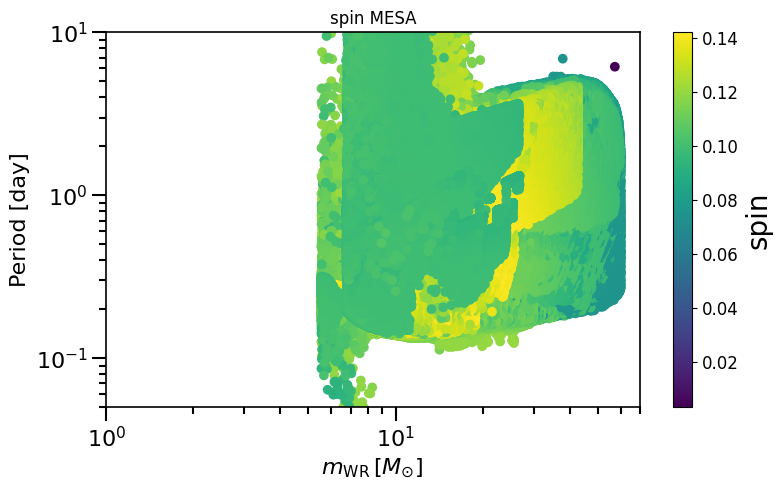

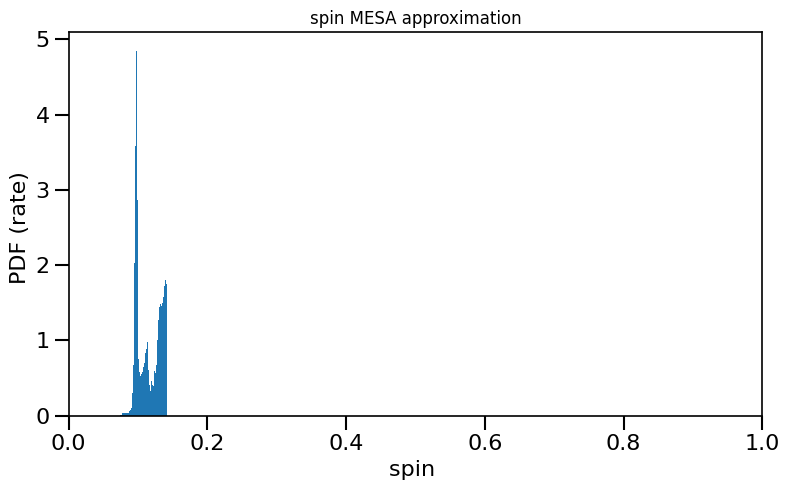

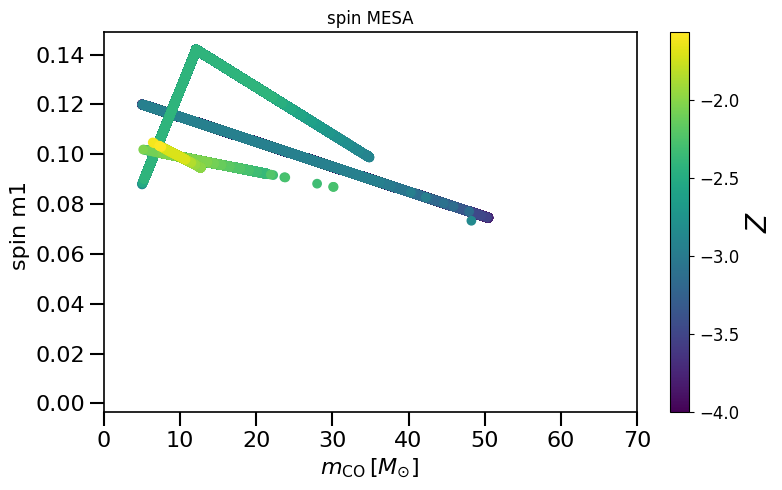

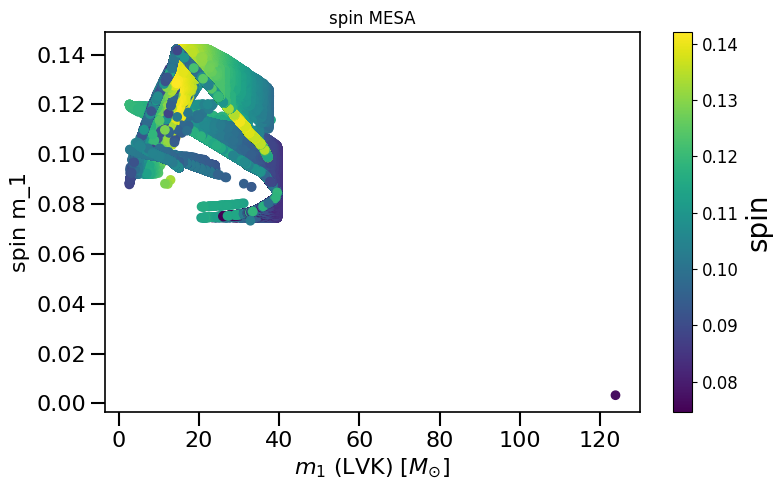

In [15]:
# give all black holes in the dataset a spin from the MESA model prescription 
# plot_scatter_spin might take a lot of time, in that case, go into the code of plot_scatter_spin and only plot a subset of the datapoints in the plt.scatter()


spin = calculate_spin_olderCOMPASdata(data_path=path)
spinM1, spinM2  = spin.MESA()


plot_scatter_spin(spin_values=(spinM1), spin_model_name=' MESA')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1), spin_model_name=' MESA approximation', weights=w_intrinsic)


plot_scatter_Belczynski_spin(spin_values=(spinM1), spin_model_name=' MESA')



LVKM1 = np.maximum(spin.M1, spin.M2)
plot_scatter_general(xx=LVKM1, yy=spinM1, cc=spinM2, spin_model_name=' MESA', xlabel=r'$m_1$ (LVK) $[M_{\odot}]$', ylabel='spin m_1')



# BHNS

<div class="alert alert-block alert-warning">


## Example: Bavera 

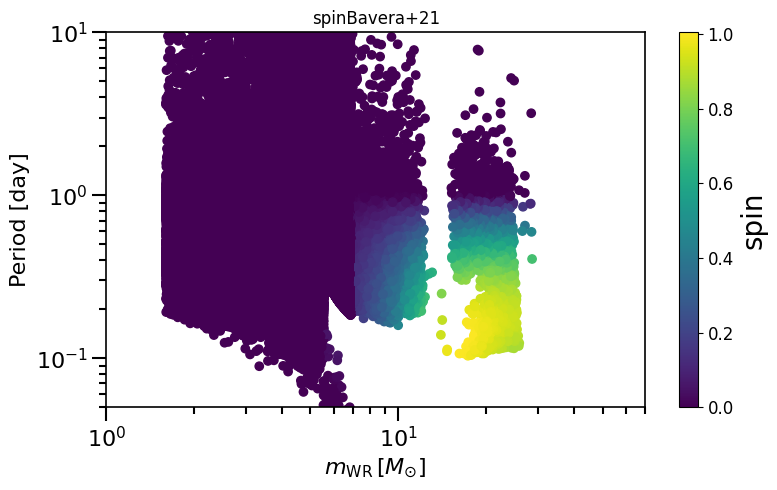

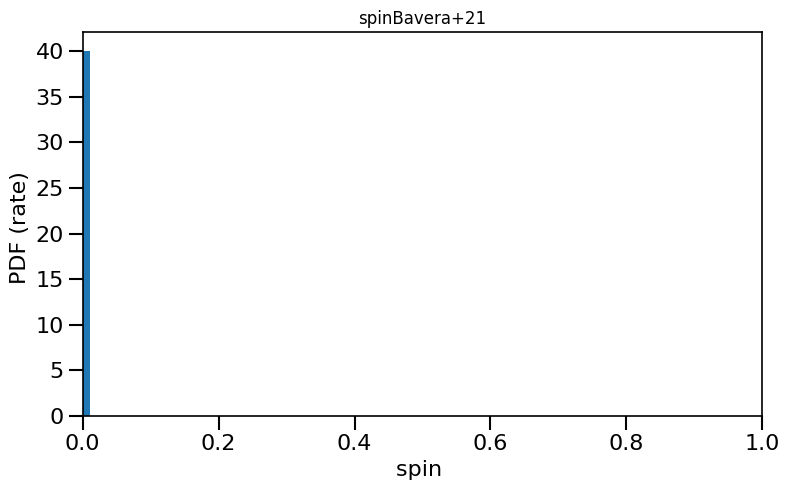

In [16]:
# give all black holes in the dataset a spin from the Bavera prescription 

DCOtype='BHNS'
path = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_'+ DCOtype +'_A.h5' # change this line! 

spin = calculate_spin_olderCOMPASdata(data_path=path)
spinM1, spinM2  = spin.Bavera21()


plot_scatter_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21')

fdata = h5.File(path)
w_intrinsic = fdata['weights_intrinsic']['w_112'][...].squeeze()

plot_histogram_spin(spin_values=(spinM1+spinM2), spin_model_name='Bavera+21', weights=w_intrinsic)
